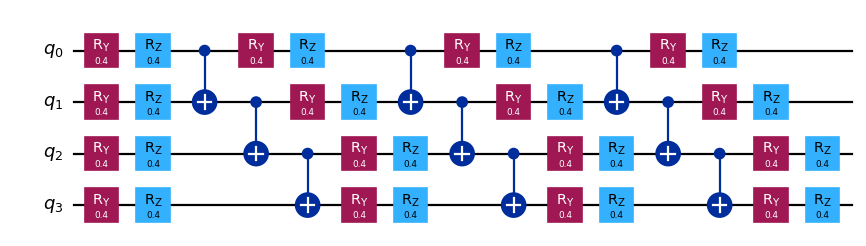

In [6]:
from qiskit.circuit.library import EfficientSU2

circuit = EfficientSU2(num_qubits=4, entanglement="linear").decompose()
circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)
circuit.draw("mpl", scale=0.8)

In [7]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])

In [8]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend, initial_layout=[0, 1, 2, 3]
)

transpiled_qc = pass_manager.run(circuit)
print(f"Transpiled circuit depth: {transpiled_qc.depth(lambda x: len(x[1]) >= 2)}")

Transpiled circuit depth: 7


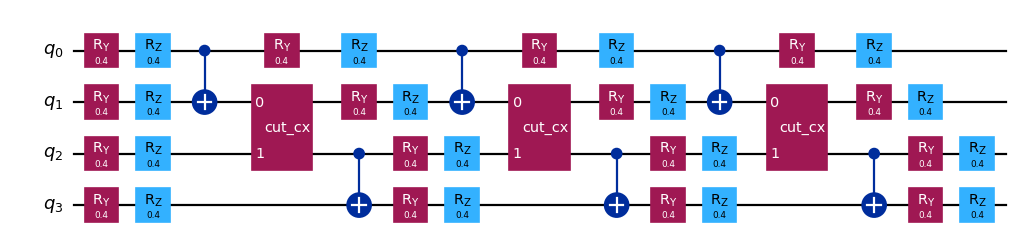

In [12]:
from circuit_knitting.cutting import cut_gates

# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {1, 2}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(circuit, cut_indices)

qpd_circuit.draw("mpl", scale=0.8)

In [14]:
import numpy as np
from circuit_knitting.cutting import generate_cutting_experiments

# Generate the subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)

Original circuit depth after transpile: 7
QPD subexperiment depth after transpile: 3


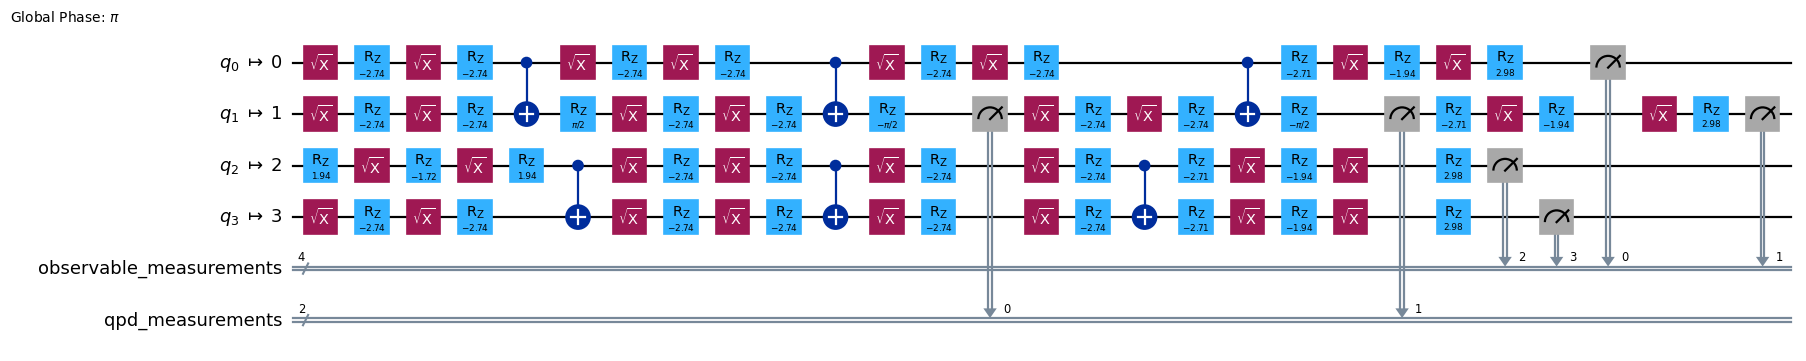

In [15]:
# Transpile the decomposed circuit to the same layout
transpiled_qpd_circuit = pass_manager.run(subexperiments[100])

print(
    f"Original circuit depth after transpile: {transpiled_qc.depth(lambda x: len(x[1]) >= 2)}"
)
print(
    f"QPD subexperiment depth after transpile: {transpiled_qpd_circuit.depth(lambda x: len(x[1]) >= 2)}"
)
transpiled_qpd_circuit.draw("mpl", scale=0.8, idle_wires=False, fold=-1)

In [11]:
import numpy as np

print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 1.0


In [7]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=100
)

In [8]:
print(f"Number of coefficients: {len(coefficients)}")

Number of coefficients: 36


In [9]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Transpile the subexperiments to ISA circuits
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

In [11]:
from qiskit_ibm_runtime import SamplerV2, Batch

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(session=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

/tmp/ipykernel_2498913/2805237936.py:6: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = SamplerV2(session=batch)


In [12]:
# Retrieve results
results = {label: job.result() for label, job in jobs.items()}

In [13]:
from circuit_knitting.cutting import reconstruct_expectation_values

# Get expectation values for each observable term
reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
print(f"Reconstructed expectation values: {reconstructed_expvals}")
# Reconstruct final expectation value
final_expval = np.dot(reconstructed_expvals, observable.coeffs)

2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
2
l 1
l 1
Reconstructed expectation values: [0.2958579659461976, 0.19120568037033092]


In [14]:
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expval = estimator.run([(qc, observable)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(final_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(final_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((final_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 0.48706365
Exact expectation value: 0.59937771
Error in estimation: -0.11231406
Relative error in estimation: -0.18738445
